---
title: "VE SDE Tutorial"
author: "Andreas Makris"
date: 2024-12-17
categories: [diffusion, tutorial]
description: "A tutorial to understand the VE Diffusion model using a toy example."
---


![](ve_diff.jpeg)

In the previous post we have seen the VP Diffusion model [DDPM](hhttps://arxiv.org/abs/2006.11239). An other popular type of Diffusion models are the Variance Exploding (VE) SDEs [SDE Diffusion](https://arxiv.org/abs/2011.13456):

$$d\boldsymbol{x}=\sqrt{\left[\frac{d}{dt}\sigma^2(t)\right]}d\boldsymbol{w}$$

with the following reverse process:

$$d\boldsymbol{x}=\left[-\frac{d}{dt}\left(\sigma^2(t)\right)\nabla_{\boldsymbol{x}}\log p_t(\boldsymbol{x})\right]dt+\sqrt{\left[\frac{d}{dt}\sigma^2(t)\right]}d\bar{\boldsymbol{w}}$$

A common choice of the variance function is $\sigma(t)=\sigma_{\text{max}}\left(\frac{\sigma_{\text{max}}}{\sigma_{\text{min}}}\right)^t$, with $\sigma_{\text{min}}=0.01$ and $\sigma_{\text{max}}=50$. Then, we have that:

$$\frac{d\sigma(t)^2}{dt}=2\sigma(t)^2\left(\log(\sigma_{\text{max}})-\log(\sigma_{\text{min}})\right)$$

Let's first understand how $\sigma(t)$ and $\frac{d\sigma(t)}{dt}$ change with time.

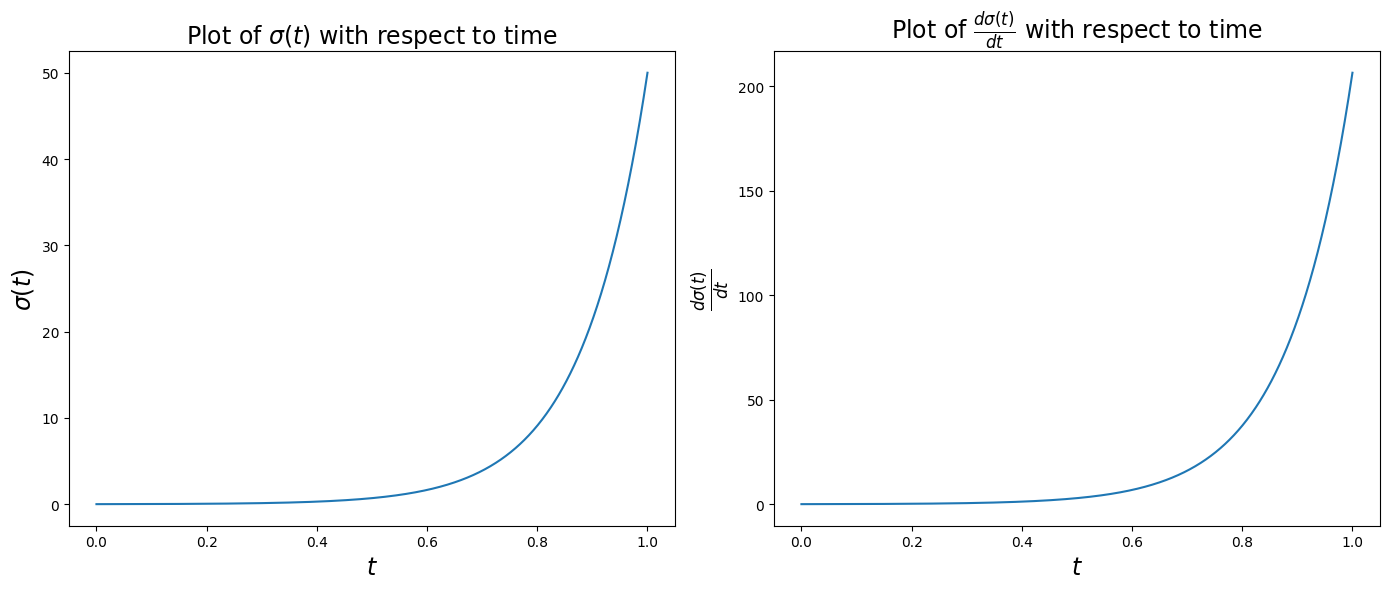

In [26]:
import numpy as np
import matplotlib.pyplot as plt

num_timesteps = 1000
dt = 1/num_timesteps
sigma_min = 0.01
sigma_max = 50

sigmas = sigma_min * (sigma_max / sigma_min) ** np.linspace(0, 1, 1000)
d2sigma_dt = 2 * sigmas ** 2 * (np.log(sigma_max) - np.log(sigma_min))

# Create a figure and two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# First subplot
ax1 = axes[0]
# Example plot (replace with your data)
ax1.plot(np.linspace(0, 1, 1000), sigmas)
# Set title and x-label for the first subplot
ax1.set_title(r'Plot of $\sigma(t)$ with respect to time', fontsize=17)
ax1.set_xlabel(r'$t$', fontsize=17)
ax1.set_ylabel(r'$\sigma(t)$', fontsize=17)

# Second subplot
ax2 = axes[1]
# Example plot (replace with your data)
ax2.plot(np.linspace(0, 1, 1000), np.sqrt(d2sigma_dt))
# Set title and x-label for the second subplot
ax2.set_title(r'Plot of $\frac{d\sigma(t)}{dt}$ with respect to time', fontsize=17)
ax2.set_xlabel(r'$t$', fontsize=17)
ax2.set_ylabel(r'$\frac{d\sigma(t)}{dt}$', fontsize=17)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

Now let's consider $p_0(x)=\mathcal{N}(5,4)$ and propagate data samples $x(0)$ to $x(1)$. The distribution of $x(1), p_1(x)$ is some noise distribution we will use to generate data samples, by propagating in reverse time.

Estimated mean is 5.073878288269043
Estimated std is 50.15424346923828


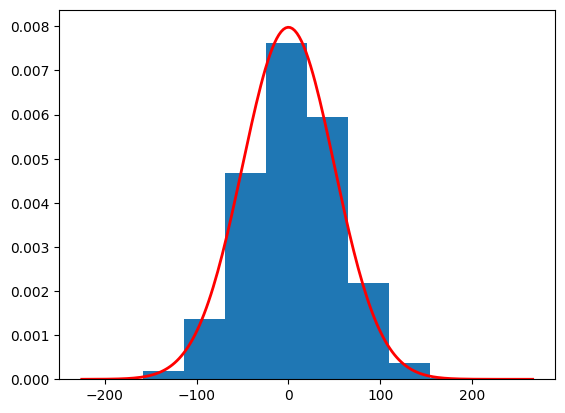

In [42]:
import torch
import numpy as np
import matplotlib.pyplot as plt

class VE_SDE_DIFF:
    def __init__(self, num_timesteps):
        self.num_timesteps = num_timesteps
        self.dt = 1/num_timesteps
        self.sigma_min = torch.tensor(0.01)
        self.sigma_max = torch.tensor(50)

        self.sigmas = self.sigma_min * (self.sigma_max / self.sigma_min) ** torch.linspace(0, 1, num_timesteps)
        self.d2sigma_dt = 2 * self.sigmas ** 2 * (torch.log(self.sigma_max) - torch.log(self.sigma_min))
        self.forward_term = torch.sqrt(self.d2sigma_dt * self.dt)
    def forward_diff(self, x0):
        B = x0.shape[0]
        x = torch.zeros((self.num_timesteps+1,B))
        x[0] = x0
        for t in range(self.num_timesteps):
            x[t+1] = x[t] + self.forward_term[t] * torch.randn(B)
        return x
    
ve_sde = VE_SDE_DIFF(1000)
x0 = torch.randn(100000) * 2 + 5
x = ve_sde.forward_diff(x0).numpy()

plot_sample = x[1000]

print(f"Estimated mean is {np.mean(plot_sample)}")
print(f"Estimated std is {np.std(plot_sample)}")
plt.hist(plot_sample, density=True)

# Define parameters for the normal distribution
mean = 0.0
std = 50.0

# Create a range of x values
xmin, xmax = plt.xlim()
x = torch.linspace(xmin, xmax, 200).numpy()

# Compute the normal PDF: (1/(σ√(2π))) exp(-(x-μ)²/(2σ²))
pdf = (1/(std * np.sqrt(2*np.pi))) * np.exp(-0.5*((x - mean)/std)**2)

# Plot the PDF line
plt.plot(x, pdf, 'r', linewidth=2)

plt.show()


Note that for large variance small differences in the mean are negligible. Thus, $\mathcal{N}(5,50^2)\approx\mathcal{N}(0,50^2)$. Consider the case of images, that pixels are normalised between -1 and 1, then the approximation is very good.

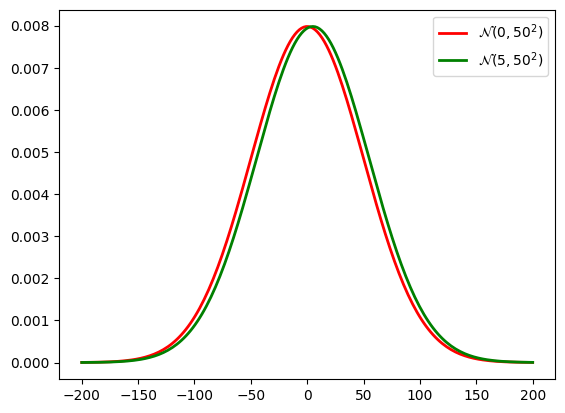

In [45]:
x = np.linspace(-200, 200, 200)
# Compute the normal PDF: (1/(σ√(2π))) exp(-(x-μ)²/(2σ²))
pdf_1 = (1/(std * np.sqrt(2*np.pi))) * np.exp(-0.5*((x - 0.0)/std)**2)
pdf_2 = (1/(std * np.sqrt(2*np.pi))) * np.exp(-0.5*((x - 5.0)/std)**2)

# Plot the PDF line
plt.plot(x, pdf_1, 'r', linewidth=2, label=r'$\mathcal{N}(0,50^2)$')
plt.plot(x, pdf_2, 'g', linewidth=2, label=r'$\mathcal{N}(5,50^2)$')

plt.legend()

plt.show()

Now we will use the exact score to perform the reverse diffusion. We assume that $p_1(x)=\mathcal{N}(5,50)$ (since we now the mean of $p_0(x)$ we can use it instead of 0). Then,

$$p_t(x)=\mathcal{N}(5, 4 + \sigma_{t}^2 - \sigma_{\text{min}}^2)$$

and 

$$\nabla_x\log p_t(x)=\frac{5-x}{4 + \sigma_{t}^2 - \sigma_{\text{min}}^2}$$

We use the exact score to reverse the diffusion process.

Estimated mean is 5.011462688446045
Estimated std is 1.9858821630477905


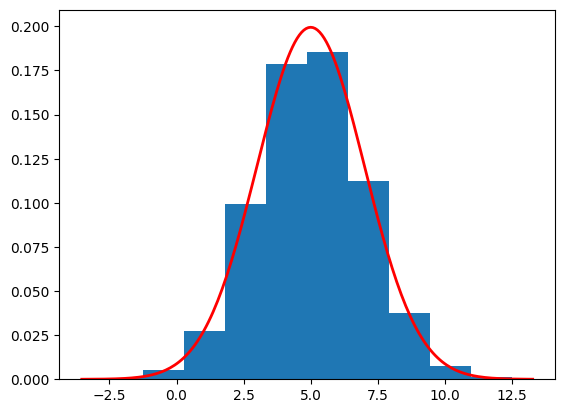

In [47]:
import torch
import numpy as np
import matplotlib.pyplot as plt

class VE_SDE_DIFF:
    def __init__(self, num_timesteps):
        self.num_timesteps = num_timesteps
        self.dt = 1/num_timesteps
        self.sigma_min = torch.tensor(0.01)
        self.sigma_min2 = self.sigma_min ** 2
        self.sigma_max = torch.tensor(50)

        self.sigmas = self.sigma_min * (self.sigma_max / self.sigma_min) ** torch.linspace(0, 1, num_timesteps)
        self.sigmas2 = self.sigmas ** 2
        self.d2sigma_dt = 2 * self.sigmas ** 2 * (torch.log(self.sigma_max) - torch.log(self.sigma_min))
        self.forward_term = torch.sqrt(self.d2sigma_dt * self.dt)
    def forward_diff(self, x0):
        B = x0.shape[0]
        x = torch.zeros((self.num_timesteps+1,B))
        x[0] = x0
        for t in range(self.num_timesteps):
            x[t+1] = x[t] + self.forward_term[t] * torch.randn(B)
        return x
    def reverse_diff(self, num_samples):
        samples = torch.zeros((self.num_timesteps+1,num_samples))
        samples[self.num_timesteps] = torch.randn(num_samples) * 50 + 5
        for t in range(self.num_timesteps-1,-1,-1):
            drift = self.d2sigma_dt[t] * self.score(samples[t+1],t+1) * self.dt
            diff = self.forward_term[t] * torch.randn(num_samples)
            samples[t] = samples[t+1] + drift + diff
        return samples
    def score(self,x,t):
        numerator = 5 - x
        denomenator = 4 + self.sigmas2[t-1] - self.sigma_min2
        return numerator / denomenator
    
ve_sde = VE_SDE_DIFF(1000)
samples = ve_sde.reverse_diff(10000).numpy()

plot_sample = samples[0]

print(f"Estimated mean is {np.mean(plot_sample)}")
print(f"Estimated std is {np.std(plot_sample)}")
plt.hist(plot_sample, density=True)

# Define parameters for the normal distribution
mean = 5.0
std = 2.0

# Create a range of x values
xmin, xmax = plt.xlim()
x = torch.linspace(xmin, xmax, 200).numpy()

# Compute the normal PDF: (1/(σ√(2π))) exp(-(x-μ)²/(2σ²))
pdf = (1/(std * np.sqrt(2*np.pi))) * np.exp(-0.5*((x - mean)/std)**2)

# Plot the PDF line
plt.plot(x, pdf, 'r', linewidth=2)

plt.show()

If you want a sanity check, try modifiying the code above, so that the we sample from $\mathcal{N}(0,50^2)$ at $t=1$. Note that the score function should not be modified!

You can also check what happens if you ignore $\sigma_{\text{min}}^2$ in the denominator of the score function. Spoiler alert: it is that small that makes no difference.